In [2]:
#First load up any packages that will be needed
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path

import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
root = Path('input', 'twitter')
file = 'train.csv'
df_train = pd.read_csv(root / file)
file = 'test.csv'
df_test = pd.read_csv(root / file)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Just to compare, a Tweet with a `target` value of 0 will be displayed next to a Tweet wotj a `target` value of 1.

In [5]:
print("Non-target Tweet: \n", df_train[df_train['target'] == 0]['text'].values[1])
print("Target Tweet: \n", df_train[df_train['target'] == 1]['text'].values[1])

Non-target Tweet: 
 I love fruits
Target Tweet: 
 Forest fire near La Ronge Sask. Canada


Next, plot the class distribution to see if there exists a difference in `target` tweets and non-`target` tweets to see if there are roughly the same amount of if the data skews in one direction.

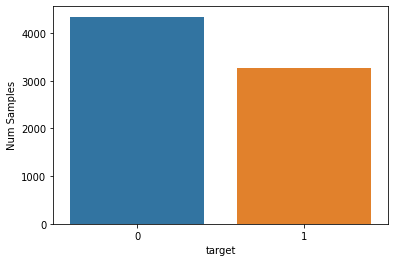

In [6]:
sns.countplot(x=df_train['target']).set_ylabel('Num Samples');

There appears to be slightly more non-`target` tweets than `target` tweets in the training dataset.

In [7]:
print("Dataframe shape: ", df_train.shape)
df_train.info()
df_train.describe(include='all')

Dataframe shape:  (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


It appears from this output, there are numerous `NaN` values in the `keyword` and `location` features.

Total missing values 2594
Location missing values 2533
Keyword missing values 61


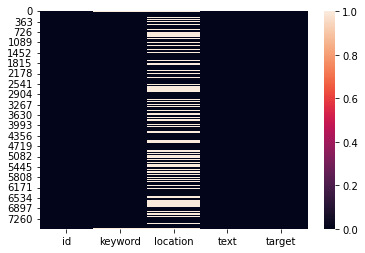

In [8]:
sns.heatmap(df_train.isna());
print("Total missing values", df_train.isna().values.sum())
print("Location missing values", df_train['location'].isna().sum())
print("Keyword missing values", df_train['keyword'].isna().sum())

It appears 2533 of the 2594 total missing values are in the `location` feature. The remaining 61 missing values are in the `keyword` feature. A large number of these just happen to appear in tweets low `id` values and as such many of the values appear as `NaN` when called by the `head()` function.

Looking at the data, there also appears to be issues with `keyword` data as it is URI encoded and has replaced spaces in between keywords with a `%20`. This should be removed.

In [9]:
df_train['keyword']  = df_train['keyword'].str.replace('%20',' ') #Replace URI encoded spaces with actual spaces

In [10]:
count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(df_train['text'])
feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,02,0215,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It appears as if there are 21,637 separate words that are vectorized! Fully examining this data, there appears to be a large amount of URLs, emojis/unicode, and punctuation (including hashtags). This should all be removed to have an accurate count to create a bag of words.

In [11]:
def strip_url(text):
    return(re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE))
def strip_emoji(text):
    return(re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # dingbats
                           u"\U000024C2-\U0001F251"  # enclosed chars
                           "]+", '', text, flags=re.UNICODE))
def strip_punct(text):
    return re.sub(r'[^\w\s]', '', text)

In [12]:
strip_url('text https://t.co/OlnK1TI1NM')

'text '

In [13]:
df_train['text'] = df_train['text'].apply(lambda r : strip_url(r))
df_train['text'] = df_train['text'].apply(lambda r : strip_emoji(r))
df_train['text'] = df_train['text'].apply(lambda r : strip_punct(r))

Recreate the bag of words to see if there are fewer columns.

In [16]:
count_vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english')
bag_of_words = count_vectorizer.fit_transform(df_train['text'])
feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,0011,001116,0025,005225,010156,010217,0104,010401,0106,0111,...,zoom,zotar50,zouma,zourryart,zrnf,zss,zumiez,zurich,zxathetis,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7610,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
for word in feature_names:
    print(word)

0011
001116
0025
005225
010156
010217
0104
010401
0106
0111
012032
012624
015025
02
0206
0215
03
0306
0308
030811
034
0400
045
05
05082015
05th
06
0605
061
063243
063424
06jst
07
070
0700
0730
075
080
0800
080215
0802pm
080515
080615
08062015
08072015
08315
0840728
09
0913
0936
0day
0npzp
10
100
1000
10000
100000
1000amp1000
1000s
1008planetu_
1008plau_
100mb
100nd
100s
101
1015
1015pm
1028
103
1030
1030pm
103424
1038pm
1040
10401
1040pm
105
106
1061
1061thetwister
10638
107
1079
109
10am
10k
10km
10m
10monthold
10news
10pm
10th
10u_
10w
10x
11
1100
11000
11000000
110358
111020
1115
112
113
1130
1130a
1130bst
11382
114
1145
115
115film
118
119000
11am
11st
11yearold
12
1200
12000
120000
1200000
12007
1211
1232
1236
124
1241317240
125
129
12hr
12jst
12m
12mm
12news
12step
12th
12u
12v
13
13000
133
1388
14
140
14000
14028
143
148
149
14hours
14th
14yearold
15
150
1500
15000270364
15000270653
150401
150foot
154107
157
1580853
1581017
159
15901
15km
15moferadio
15th
16
160
1600yearold
1611